In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import datetime
import re
from bayes_opt import BayesianOptimization

In [2]:
df = pd.read_csv('./train/ETL_ALL_v2.csv', index_col = 0)

obj_columns = df.select_dtypes(include=['object']).columns
# Apply one-hot encoding to object columns
df = pd.get_dummies(df, columns = obj_columns, drop_first = True)

y = df.TARGET
X = df.drop('TARGET', axis = 1)
X = X.replace([np.inf, -np.inf], np.nan)
X.fillna(0.0, inplace = True)

In [3]:
import xgboost as xgb

# XGBoost 直接存取 dataframe
data_dmatrix = xgb.DMatrix(data=X,label=y)

X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size = 0.1, random_state = 37)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size = 0.5, random_state = 37)

In [4]:
params = {"objective":"binary:logistic",
          'colsample_bytree': 1,
          'scale_pos_weight' : 14,
          'learning_rate': 0.1,
          'max_depth': 10, 
          'reg_alpha' : 0, 
          'early_stopping_rounds': 20, 
          'random_state' : 37
          }

evals_result = {}

start_time = time.time()

xgbm = xgb.XGBClassifier(**params)
xgbm.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='auc',
)

end_time = time.time()
execution_time = end_time - start_time

y_pred =xgbm.predict(X_test)
y_pred_prob = xgbm.predict_proba(X_test)

print("\n程式執行花費的时间：", round(execution_time, 2), "秒")
print("完成时间:", datetime.datetime.now())

c:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.70596
[1]	validation_0-auc:0.72790
[2]	validation_0-auc:0.73414
[3]	validation_0-auc:0.73819
[4]	validation_0-auc:0.74293
[5]	validation_0-auc:0.74653
[6]	validation_0-auc:0.74828
[7]	validation_0-auc:0.74972
[8]	validation_0-auc:0.75168
[9]	validation_0-auc:0.75403
[10]	validation_0-auc:0.75487
[11]	validation_0-auc:0.75740
[12]	validation_0-auc:0.75801
[13]	validation_0-auc:0.75869
[14]	validation_0-auc:0.75977
[15]	validation_0-auc:0.76130
[16]	validation_0-auc:0.76282
[17]	validation_0-auc:0.76467
[18]	validation_0-auc:0.76532
[19]	validation_0-auc:0.76517
[20]	validation_0-auc:0.76625
[21]	validation_0-auc:0.76691
[22]	validation_0-auc:0.76816
[23]	validation_0-auc:0.76840
[24]	validation_0-auc:0.76880
[25]	validation_0-auc:0.76937
[26]	validation_0-auc:0.77034
[27]	validation_0-auc:0.77143
[28]	validation_0-auc:0.77140
[29]	validation_0-auc:0.77204
[30]	validation_0-auc:0.77236
[31]	validation_0-auc:0.77291
[32]	validation_0-auc:0.77341
[33]	validation_0-au

<Axes: title={'center': 'Feature importance'}, xlabel='weight', ylabel='Features'>

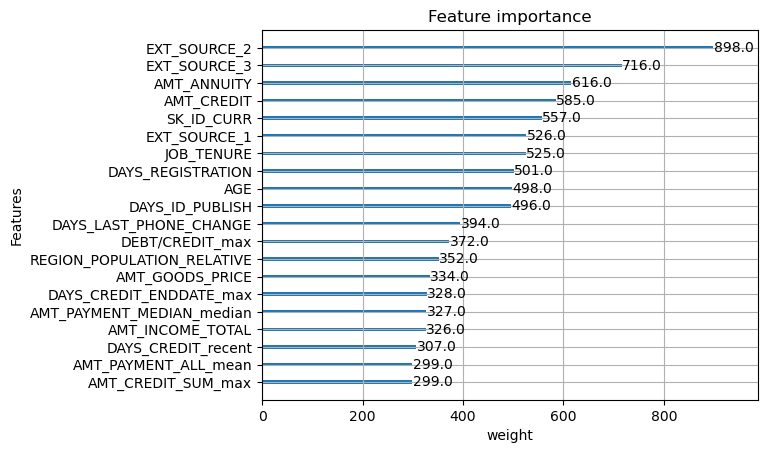

In [5]:
# weight: the number of times a feature is used to split the data across all trees.weight
xgb.plot_importance(xgbm, max_num_features=20, importance_type='weight', xlabel= 'weight')

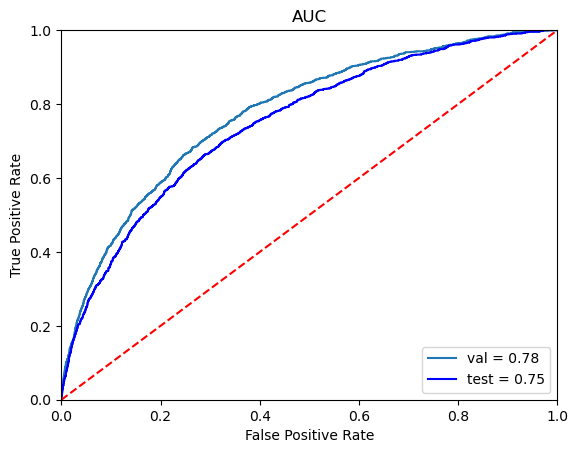

In [6]:
y_pred_prob = xgbm.predict_proba(X_val)
y_pred_prob = y_pred_prob[:,1]
fpr, tpr, thresh = metrics.roc_curve(y_val, y_pred_prob)
auc = metrics.roc_auc_score(y_val, y_pred_prob)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr,tpr,label="val = %0.2f" % roc_auc)

y_pred_prob = xgbm.predict_proba(X_test)
y_pred_prob = y_pred_prob[:,1]
fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred_prob)
roc_auc = metrics.auc(fpr, tpr)
plt.title('AUC')
plt.plot(fpr, tpr, 'b', label='test = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

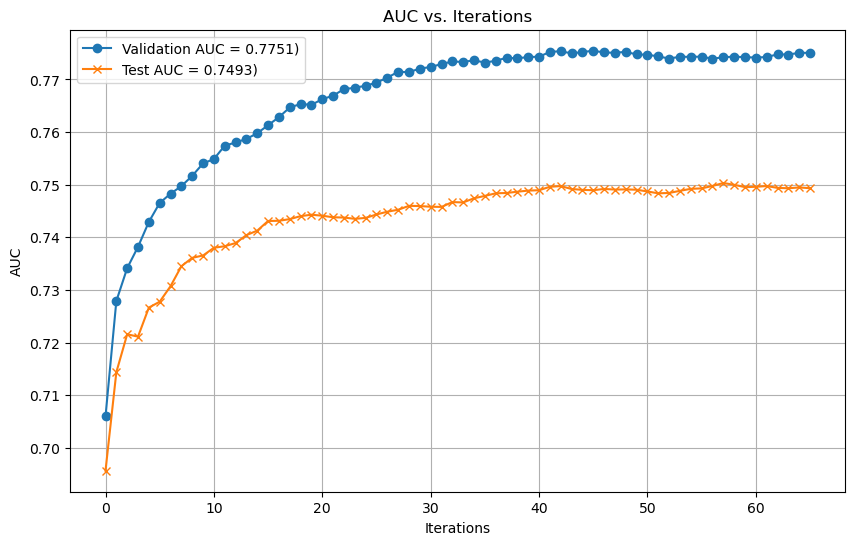

In [7]:
from sklearn.metrics import roc_curve, auc
# 初始化验证集和测试集的真实标签
y_true_valid = y_val
y_true_test = y_test
eval_result = xgbm.evals_result()

# 获取迭代次数和AUC值的记录
iterations = (0, len(eval_result['validation_0']['auc']))
valid_auc_values = eval_result['validation_0']['auc']

# 初始化存储AUC值的列表
valid_auc = []
test_auc = []

# 使用模型的predict_proba方法来获取概率值
for iteration in list(range(iterations[0], iterations[1] + 1)):
    y_pred_prob_valid = xgbm.predict_proba(X_val, iteration_range=(0, iteration))[:, 1]
    y_pred_prob_test = xgbm.predict_proba(X_test, iteration_range=(0, iteration))[:, 1]

    # 计算验证集和测试集的ROC曲线
    fpr_valid, tpr_valid, _ = roc_curve(y_true_valid[:], y_pred_prob_valid)
    fpr_test, tpr_test, _ = roc_curve(y_true_test[:], y_pred_prob_test)

    # 计算验证集和测试集的AUC值
    roc_auc_valid = auc(fpr_valid, tpr_valid)
    roc_auc_test = auc(fpr_test, tpr_test)

    # 将AUC值添加到列表中
    valid_auc.append(roc_auc_valid)
    test_auc.append(roc_auc_test)

# 绘制AUC曲线
plt.figure(figsize=(10, 6))
array_result = np.array(list(range(iterations[0], iterations[1])))
plt.plot(array_result, valid_auc[1:], label=f'Validation AUC = {valid_auc[-1]:.4f})', marker='o')
plt.plot(array_result, test_auc[1:], label=f'Test AUC = {test_auc[-1]:.4f})', marker='x')
plt.xlabel('Iterations')
plt.ylabel('AUC')
plt.title('AUC vs. Iterations')
plt.legend()
plt.grid(True)
plt.show()

Pipeline 寫法 (Z-score & XGBClassfier)

In [5]:
# params = {"objective":"binary:logistic",'colsample_bytree': 1, 'scale_pos_weight' : 14, 'learning_rate': 0.1,
#           'max_depth': 10, 'reg_alpha' : 0, 'early_stopping_rounds': 20, 'random_state' : 37}

# pipe_xgb = Pipeline([('scaler', StandardScaler()), ('xgb', XGBClassifier(**params))])

# t0 = time.time()

# pipe_xgb.fit(X_train.values, y_train.values, 
#             # xgb__early_stopping_rounds=20,
#             xgb__eval_set = [(X_train.values, y_train.values), (X_test.values, y_test.values)],
#             xgb__eval_metric = 'error')
# t1 = time.time()
# y_pred = pipe_xgb.predict(X_test)
# y_trainPred = pipe_xgb.predict(X_train)

# print('XGBoost elapse time: {}'.format(t1-t0))

c:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.40872	validation_1-error:0.40713
[1]	validation_0-error:0.26070	validation_1-error:0.25976
[2]	validation_0-error:0.11751	validation_1-error:0.11869
[3]	validation_0-error:0.21584	validation_1-error:0.21729
[4]	validation_0-error:0.11263	validation_1-error:0.11401
[5]	validation_0-error:0.12854	validation_1-error:0.12962
[6]	validation_0-error:0.11360	validation_1-error:0.11733
[7]	validation_0-error:0.10402	validation_1-error:0.10640
[8]	validation_0-error:0.10304	validation_1-error:0.10594
[9]	validation_0-error:0.09760	validation_1-error:0.10009
[10]	validation_0-error:0.09858	validation_1-error:0.10107
[11]	validation_0-error:0.09863	validation_1-error:0.10061
[12]	validation_0-error:0.10018	validation_1-error:0.10256
[13]	validation_0-error:0.09278	validation_1-error:0.09508
[14]	validation_0-error:0.09344	validation_1-error:0.09586
[15]	validation_0-error:0.10334	validation_1-error:0.10523
[16]	validation_0-error:0.09495	validation_1-error:0.09762
[17]	va

c:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


XGBoost elapse time: 174.22923612594604


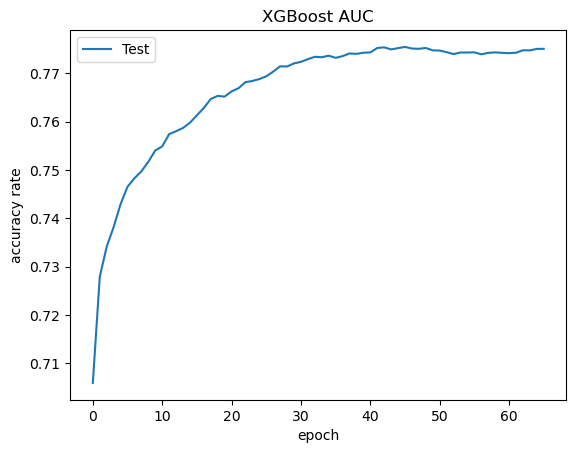

In [7]:
# from sklearn.metrics import accuracy_score

# y_pred = pipe_xgb.predict(X_test)
# print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

results = xgbm.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
acc = [x for x in results['validation_0']['auc']]
fig, ax = plt.subplots()
ax.plot(x_axis, acc, label='Test')
ax.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy rate')
plt.title('XGBoost AUC')
plt.show()

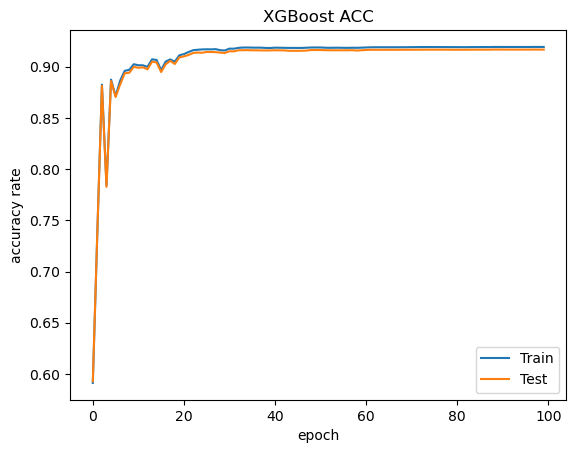

In [6]:
# from sklearn.metrics import accuracy_score

# y_pred = pipe_xgb.predict(X_test)
# print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

# results = pipe_xgb.named_steps["xgb"].evals_result()
# epochs = len(results['validation_0']['error'])
# x_axis = range(0, epochs)
# acc = [np.abs(x - 1) for x in results['validation_0']['error']]
# acc2 = [np.abs(x - 1) for x in results['validation_1']['error']]
# fig, ax = plt.subplots()
# ax.plot(x_axis, acc, label='Train')
# ax.plot(x_axis, acc2, label='Test')
# ax.legend()
# plt.xlabel('epoch')
# plt.ylabel('accuracy rate')
# plt.title('XGBoost ACC')
# plt.show()

In [ ]:
# from sklearn.model_selection import cross_val_score

# scores = cross_val_score(estimator = pipe_xgb,
#                         X = X_train,
#                         y = y_train,
#                         cv = 10,
#                         scoring = 'accuracy',
#                         n_jobs = -1)

# print('CV accuracy: %.3f +/- %.3f'% ((np.mean(scores)) , np.std(scores)))

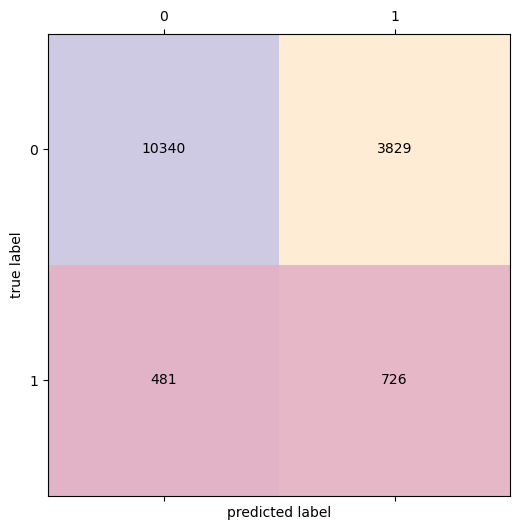

In [22]:
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize = (6, 6))
ax.matshow(confmat, cmap = 'Spectral', alpha = 0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i,
                s=confmat[i,j],
                va='center',ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

In [9]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.78      0.86     14169
           1       0.18      0.58      0.27      1207

    accuracy                           0.76     15376
   macro avg       0.57      0.68      0.56     15376
weighted avg       0.89      0.76      0.81     15376



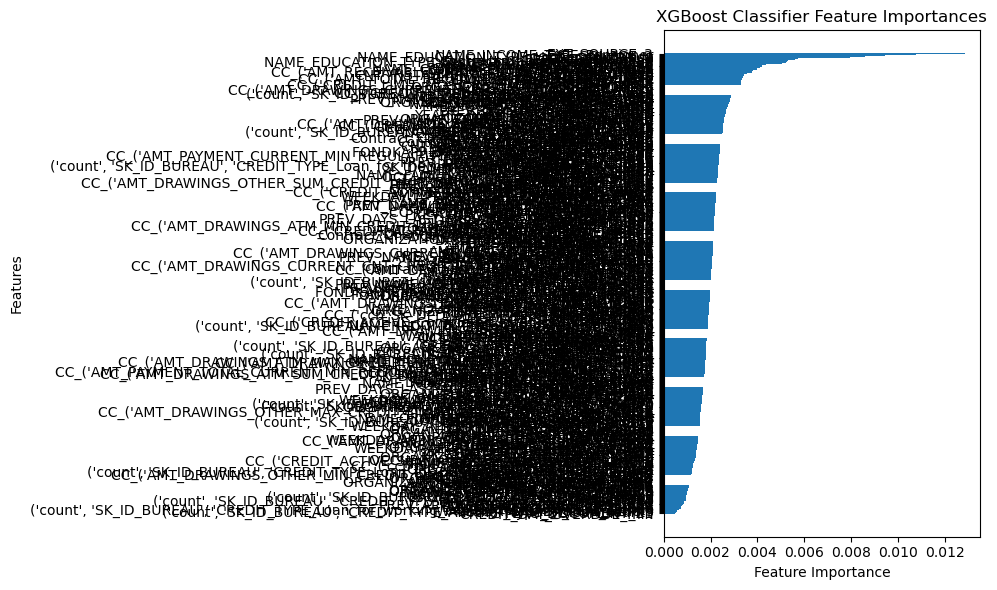

In [9]:
# feature_importances = pipe_xgb.steps[1][1].feature_importances_

# Get feature names from the pipeline
# feature_names = X_train.columns

# Sort feature importances in ascending order
# sorted_indices = np.argsort(feature_importances)[::1]
# sorted_feature_importances = feature_importances[sorted_indices]
# sorted_feature_names = feature_names[sorted_indices]

# important_indices = np.where(sorted_feature_importances != 0)[0]
# important_feature_importances = sorted_feature_importances[important_indices]
# important_feature_names = sorted_feature_names[important_indices]
# # Plotting
# plt.figure(figsize=(10, 6))
# plt.barh(range(len(important_feature_importances)), important_feature_importances, tick_label=important_feature_names)
# plt.xlabel('Feature Importance')
# plt.ylabel('Features')
# plt.title('XGBoost Classifier Feature Importances')
# plt.tight_layout()
# plt.show()

In [ ]:
# import pickle
# file_name = "xgb_clf.pkl"

# # save
# pickle.dump(pipe_xgb, open(file_name, "wb"))

# evaluate model 
data = {
    "AMT_INCOME_TOTAL": [600],
    "CODE_GENDER_M": [0],
    "CODE_GENDER_XNA" : [0],
    "FLAG_OWN_CAR_Y": [0],
    "FLAG_OWN_REALTY_Y": [0]
}
data = pd.DataFrame(data)
y_pred = loaded_model.predict_proba(data)

# check results
print(y_pred[0][0])

0.48623538


c:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


調參工具: 貝葉斯優化

Model I/O

In [ ]:
# import pickle
# file_name = "xgb_clf.pkl"

# # save
# pickle.dump(pipe_xgb, open(file_name, "wb"))

In [ ]:
## 給顥瑋哥的測試版模型
# import pickle
# import pandas as pd
# file_name = "test.pkl"

# # # save
# # pickle.dump(pipe_xgb, open(file_name, "wb"))

# # load
# xgb_model_loaded = pickle.load(open('./model/'+file_name, "rb"))

# # test
# data = {
#     "AMT_INCOME_TOTAL": [600],
#     "CODE_GENDER_M": [0],
#     "CODE_GENDER_XNA" : [0],
#     "FLAG_OWN_CAR_Y": [0],
#     "FLAG_OWN_REALTY_Y": [0]
# }
# data = pd.DataFrame(data)
# print(xgb_model_loaded.predict_proba(data)[0][0]) # 不違約 (0) 的機率 0.9